<a href="https://colab.research.google.com/github/nbembi/AA_500_USD_Group9_CustomerSegmentation/blob/dev/01_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# G9: Probability and Statistics for Artificial Intelligence (AAI-500-IN2)

## Introduction : Nehpreet
Our project looks at a UK-based online retail for gift sales dataset.

Conduct a descriptive analysis of the Online Retail dataset as part of your data analysis project. We have a transactional dataset with 541,909 instances and 6 key features: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, and Country.



In [1]:
pip install ucimlrepo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from ucimlrepo import fetch_ucirepo
from datetime import datetime

In [3]:
# fetch dataset
online_retail = fetch_ucirepo(id=352)

# data (as pandas dataframes)
X = online_retail.data.features
y = online_retail.data.targets

online_retail_df = online_retail.data.original


## Data Cleaning and Preparation

### Preview the data

First 5 rows of the dataset:

In [4]:
# Display first few rows
online_retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Display the data types:

In [5]:
online_retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Check for missing values


Missing Values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


<Figure size 800x600 with 0 Axes>

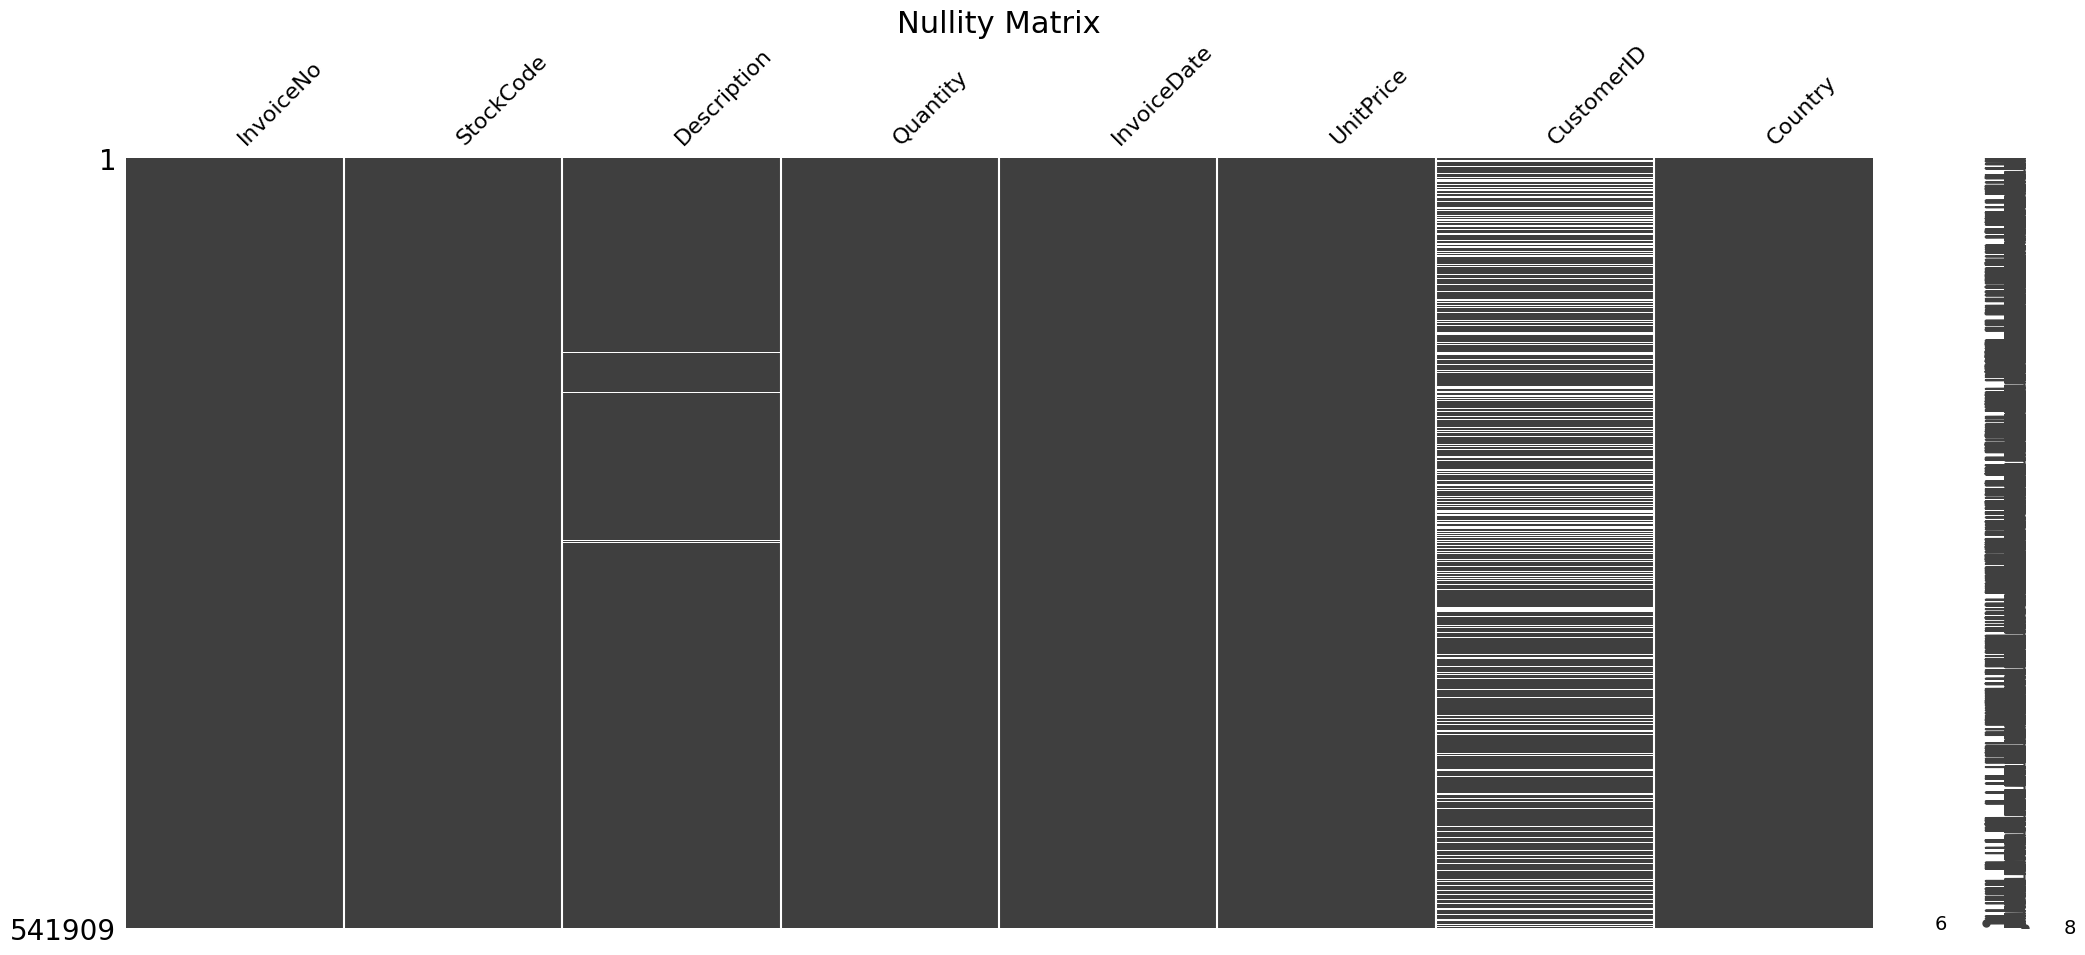

In [6]:
# Check for missing values
print("\nMissing Values:")
print(online_retail_df.isnull().sum())

# Show nullity across all columns
plt.figure(figsize=(8, 6))
msno.matrix(online_retail_df)
plt.title('Nullity Matrix', fontsize=22)
plt.show()



### Missing Percentage

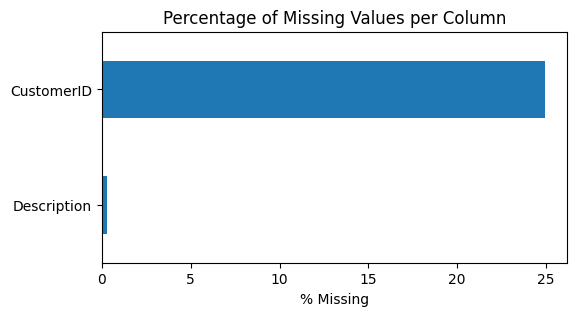

In [7]:
missing_percent = online_retail_df.isnull().mean() * 100

plt.figure(figsize=(6, 3))
missing_percent[missing_percent > 0].sort_values().plot.barh()
plt.title('Percentage of Missing Values per Column')
plt.xlabel('% Missing')
plt.show()

We have seen the first 5 rows, data types, and missing value counts. The dataset has no missing values as per the documentation, but we verified this anyways. The `InvoiceDate` may need parsing as a datetime object, and `CustomerID` might be float but should be treated as categorical.

We miss 25% of customer IDs , sicne custoemr IDs are required field in the data and is the base of our analysis , we can not impute the information of missing customer IDs

## Data Cleaning and Preparation

Even though the dataset has no missing values, we need to:

- Convert `InvoiceDate` to datetime.
- Check for cancellations (transactions where `InvoiceNo` starts with 'C').
- Ensure `CustomerID` is treated as a string (categorical).
- Look for outliers or invalid data (e.g., negative `Quantity` or `UnitPrice`).
- Add a `TotalPrice` to allow revenue analysis

#### Update Data Types

In [8]:
# Convert InvoiceDate to datetime
online_retail_df['InvoiceDate'] = pd.to_datetime(online_retail_df['InvoiceDate'])
online_retail_df['DateID'] = online_retail_df['InvoiceDate'].dt.date
online_retail_df['DateID'] = pd.to_datetime(online_retail_df['DateID'])


# Convert CustomerID to string (categorical) and remove '.0'
online_retail_df['CustomerID'] = online_retail_df['CustomerID'].astype(str).str.replace(r'\.0$', '', regex=True)

#### Identify Cancellations in the data


In [9]:
# Identify cancellations
online_retail_df['IsCancelled'] = online_retail_df['InvoiceNo'].str.startswith('C')



#### Creating Total Price Column

In [10]:
# Calculate TotalPrice

online_retail_df['TotalPrice'] = online_retail_df['Quantity'] * online_retail_df['UnitPrice']

online_retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DateID,IsCancelled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,False,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,False,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,False,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,False,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,False,20.34


#### Treatment of Outliers

The `Quantity` field includes both positive and negative values (negative likely due to cancellations, as `InvoiceNo` starting with 'C' indicates)

- Negative quantities (cancellations) may affect the shape of the distribution.
- The data may have extreme positive outliers (e.g., bulk orders).
- The underlying distribution might be log-normal rather than normal, which is common for quantities in retail data.

To address outliers, we can follow several approaches:

- **Option 1: Filter Out Negative Quantities (Cancellations)**  
  Since negative quantities likely represent cancellations, you can exclude them to focus on actual sales.
  ```python
  # Filter out cancellations and negative quantities
  df = df[(df['IsCancelled'] == False) & (df['Quantity'] > 0)]
  ```
- **Option 2: Winsorize or Cap Outliers**  
  Winsorizing replaces extreme values with a specified percentile threshold (e.g., 1st and 99th percentiles), reducing the impact of outliers without removing data.
  ```python
  # Winsorize Quantity at 1st and 99th percentiles
  df['QuantityWinsorized'] = mstats.winsorize(df['Quantity'], limits=[0.01, 0.01])
  ```
- **Option 3: Remove Extreme Outliers Using IQR**  
  Use the Interquartile Range (IQR) method to identify and remove outliers, keeping data within 1.5 times the IQR from the quartiles.
  ```python
  # Calculate IQR
  Q1 = df['Quantity'].quantile(0.25)
  Q3 = df['Quantity'].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Filter out outliers
  df = df[(df['Quantity'] >= lower_bound) & (df['Quantity'] <= upper_bound)]
  ```

#### Identifying Outliers -- Using IQR

In [21]:
# Calculate IQR
# def identify_outliers_iqr(group):
#     Q1 = group['TotalPrice'].quantile(0.25)
#     Q3 = group['TotalPrice'].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     # Mark outliers
#     group['lower_bound'] = lower_bound
#     group['upper_bound'] = upper_bound
#     group['IsOutlier'] = (group['Quantity'] < lower_bound) | (group['Quantity'] > upper_bound)
#     return group

def identify_quantile_outliers(group, column='TotalPrice', lower_q=0.05, upper_q=0.95):
    lower_bound = group[column].quantile(lower_q)
    upper_bound = group[column].quantile(upper_q)

    group['lower_bound'] = lower_bound
    group['upper_bound'] = upper_bound
    group['IsOutlier'] = (group[column] < lower_bound) | (group[column] > upper_bound)
    return group

outlier_df = online_retail_df.groupby(['CustomerID', 'StockCode'], group_keys=False).apply(identify_quantile_outliers)
outlier_df.head()

/tmp/ipython-input-21-1588716957.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outlier_df = df.groupby(['CustomerID', 'StockCode'], group_keys=False).apply(identify_quantile_outliers)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DateID,TotalPrice,IsCancelled,IsOutlier
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,15.30,False,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,20.34,False,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,22.00,False,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,20.34,False,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,20.34,False,False


In [28]:
outlier_df[outlier_df["IsOutlier"]==True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DateID,TotalPrice,IsCancelled,IsOutlier
12,536367,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,8,2010-12-01 08:34:00,3.75,13047,United Kingdom,2010-12-01,30.00,False,True
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583,France,2010-12-01,90.00,False,True
30,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583,France,2010-12-01,15.60,False,True
34,536370,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,2010-12-01 08:45:00,2.95,12583,France,2010-12-01,70.80,False,True
35,536370,22629,SPACEBOY LUNCH BOX,24,2010-12-01 08:45:00,1.95,12583,France,2010-12-01,46.80,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
541869,581585,22481,BLACK TEA TOWEL CLASSIC DESIGN,12,2011-12-09 12:31:00,0.39,15804,United Kingdom,2011-12-09,4.68,False,True
541870,581585,22915,ASSORTED BOTTLE TOP MAGNETS,24,2011-12-09 12:31:00,0.19,15804,United Kingdom,2011-12-09,4.56,False,True
541873,581585,84832,ZINC WILLIE WINKIE CANDLE STICK,24,2011-12-09 12:31:00,0.85,15804,United Kingdom,2011-12-09,20.40,False,True
541879,581585,22726,ALARM CLOCK BAKELIKE GREEN,8,2011-12-09 12:31:00,3.75,15804,United Kingdom,2011-12-09,30.00,False,True


In [29]:
outlier_df[(outlier_df["CustomerID"]=="12583")&(outlier_df["StockCode"]=="22728")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DateID,TotalPrice,IsCancelled,IsOutlier
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583,France,2010-12-01,90.0,False,True
47885,540455,22728,ALARM CLOCK BAKELIKE PINK,12,2011-01-07 12:07:00,3.75,12583,France,2011-01-07,45.0,False,False
235164,557627,22728,ALARM CLOCK BAKELIKE PINK,4,2011-06-21 14:30:00,3.75,12583,France,2011-06-21,15.0,False,False
256080,559441,22728,ALARM CLOCK BAKELIKE PINK,4,2011-07-08 12:22:00,3.75,12583,France,2011-07-08,15.0,False,False
349924,567552,22728,ALARM CLOCK BAKELIKE PINK,8,2011-09-21 10:40:00,3.75,12583,France,2011-09-21,30.0,False,False
448652,575067,22728,ALARM CLOCK BAKELIKE PINK,12,2011-11-08 12:45:00,3.75,12583,France,2011-11-08,45.0,False,False
532935,581001,22728,ALARM CLOCK BAKELIKE PINK,18,2011-12-07 08:07:00,3.75,12583,France,2011-12-07,67.5,False,False


### Negative Values

Negative quantities might indicate returns or cancellations, which we'll analyze separately.

If negative `UnitPrice` exists, it could be an error unless it represents adjustments.

We'll keep cancellations for now to analyze their impact.

In [11]:
# Check for negative quantities or prices
print("\nNegative Quantities:", (online_retail_df['Quantity'] < 0).sum())
print("Negative Unit Prices:", (online_retail_df['UnitPrice'] < 0).sum())

# Basic data cleaning: Remove invalid entries if needed
#df = df[df['Quantity'] >= 0] #Drop negative Quantity if they exist
valid_units_df = online_retail_df[online_retail_df['UnitPrice'] >= 0] #Drop negative UnitPrice if they exist

# Filter out cancellations
df_cancellations = valid_units_df[(valid_units_df['IsCancelled'] == True)]
valid_tansactions = valid_units_df[(valid_units_df['IsCancelled'] == False)]


Negative Quantities: 10624
Negative Unit Prices: 2


## Exploratory Data Analysis (EDA)

For our exploratory data analysis, we will initially just try to understand the data we have. It might be important to formulate a number of research questions that will help structure our EDA i.e. give us something to look for in the data.

### Research Questions

When we look at the variables: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, and the derived TotalPrice and IsCancelled, we can start thinking of inferential research questions that we can ask on this dataset.

Inferential analysis aims to draw conclusions about the population beyond descriptive summaries, often using statistical tests or models to test hypotheses or predict outcomes.

Goals for our inferential analysis could include testing hypotheses, identifying relationships, or predicting outcomes to inform business decisions (e.g. customer behavior, sales trends).

1. Understand Customer Behavior and Segmentation: *Do customers from different countries have significantly different purchasing patterns (e.g. average order value or frequency)?*   
  Understanding country-based differences can inform targeted marketing strategies. We could use use ANOVA to test if mean TotalPrice differs across countries.

2. Understanding Cancellation Patterns: *Are cancellations (IsCancelled) more likely for specific product types or customer segments?*  
  Identifying cancellation drivers can reduce revenue loss. We can use a regression model to predict IsCancelled using features like StockCode, Quantity, UnitPrice, and Country. Chi-square tests can assess associations between cancellations and categorical variables.

3. Identify Trends in Sales Over Time: *Is there a significant seasonal effect on sales volume or transaction frequency?*  
  Detecting seasonality can optimize inventory and marketing campaigns. This could be done through time-series analysis to identify seasonality.

4. Determine Product Popularity and Revenue Contribution: *Do certain products (StockCode) contribute disproportionately to total revenue, and are these differences statistically significant?*  
  Identifying top-performing products aids inventory management. Perform analysis to identify top revenue-generating products, followed by t-tests or ANOVA to compare TotalPrice across product groups.

5. Insgihts Into Customer Retention: *Do first-time customers have a significantly lower likelihood of repeat purchases compared to returning customers?*  
  Retention insights can guide customer loyalty programs. Define first-time vs. returning customers based on CustomerID and InvoiceDate. Develop models (e.g. regression, survival analysis, etc) to predict repeat purchase likelihood.

### Descriptive Statistics

Given that this is a dataset for an online retailer store, we may expect to find:  

* `Quantity` and `UnitPrice` may have skewed distributions (e.g., large orders or high-priced items).
* `Country` will likely show the UK as dominant (since it's UK-based retail).
* Cancellations (`IsCancelled`) will help quantify returns.
* The date range confirms transactions from Dec 2010 to Dec 2011.

In [12]:
# Top 5 countries by transaction count
print("\nTop 5 Countries by Transaction Count:")
valid_tansactions['Country'].value_counts().head()



Top 5 Countries by Transaction Count:


,count
Country,
United Kingdom,487620
Germany,9042
France,8408
EIRE,7894
Spain,2485


In [14]:
# Transaction date range
print("\nDate Range:")
print(f"From: {valid_tansactions['InvoiceDate'].min()} to {valid_tansactions['InvoiceDate'].max()}")


Date Range:
From: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


#### Descriptive Statistics for Numerical Features:

In [15]:
numeric_cols = ['Quantity', 'UnitPrice']

# Numerical features summary
stats = valid_tansactions[numeric_cols].describe().T
stats['IQR'] = stats['75%'] - stats['25%']
stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'IQR']].T

,Quantity,UnitPrice
count,532619.000000,532619.000000
mean,10.240006,3.889174
std,159.593850,35.831786
min,-9600.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000
IQR,9.000000,2.880000


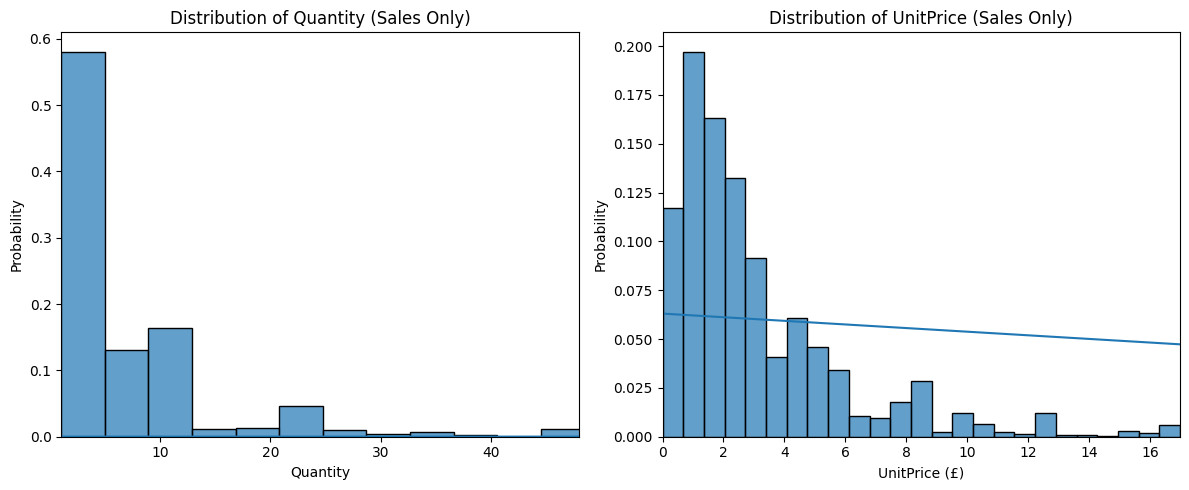

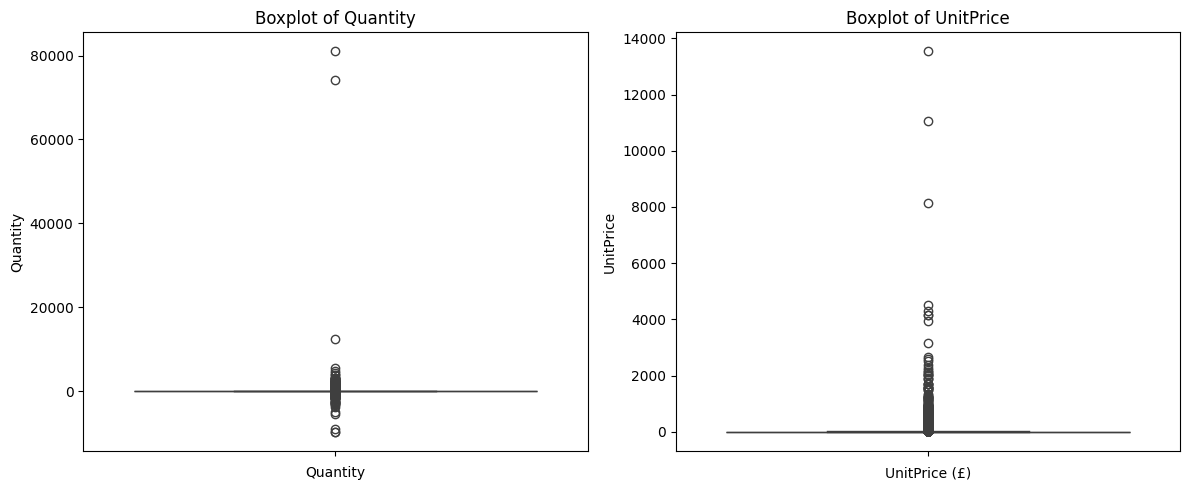

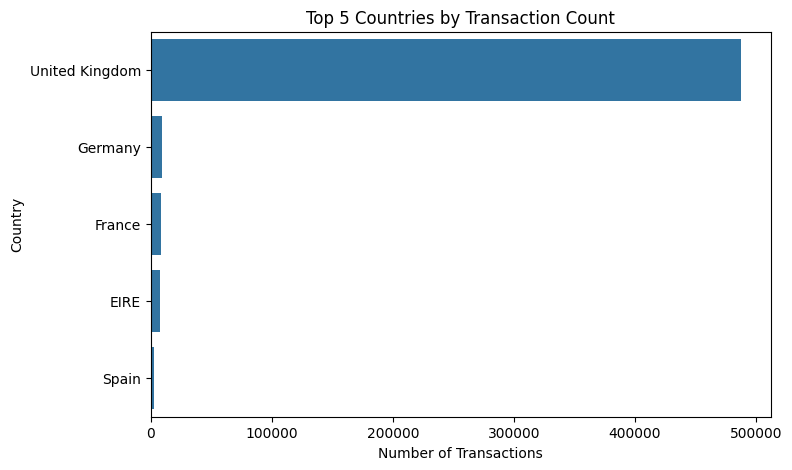

/tmp/ipython-input-16-2831297312.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_tansactions['InvoiceMonth'] = valid_tansactions['InvoiceDate'].dt.to_period('M')


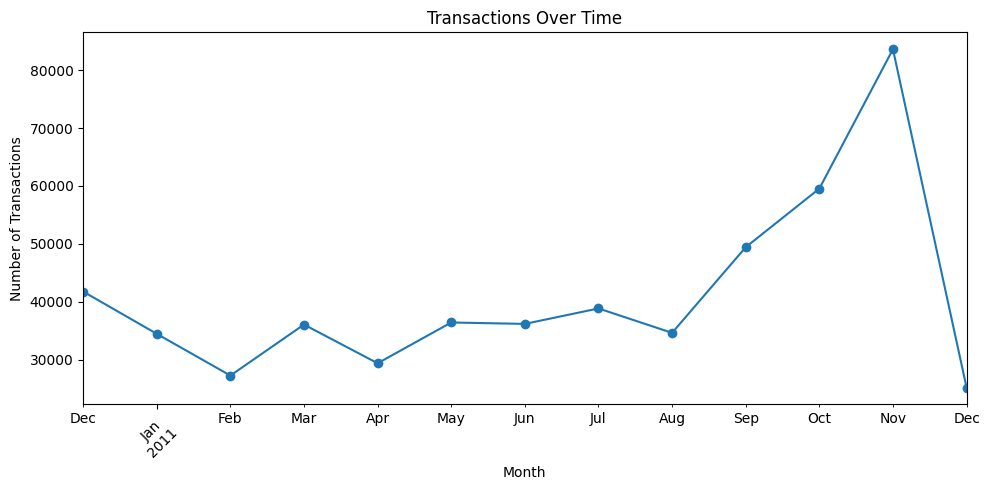

In [16]:
# Set plot style
#plt.style.use('seaborn')

# Histogram for Quantity and UnitPrice
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bin_edges = np.linspace(
    # for this data, after trial and error,
    # we rather define our own explicit bins
    valid_tansactions['Quantity'].quantile(0.01),
    valid_tansactions['Quantity'].quantile(0.99),
    26  # 25 bins needs 26 edges
)
sns.histplot(valid_tansactions['Quantity'], bins=bin_edges, kde=True, stat='probability', edgecolor='black', linewidth=1, alpha=0.7)
plt.title('Distribution of Quantity (Sales Only)')
plt.xlabel('Quantity')
plt.xlim(valid_tansactions['Quantity'].quantile(0.025), valid_tansactions['Quantity'].quantile(0.975))  # Limit outliers

plt.subplot(1, 2, 2)
bin_edges = np.linspace(
    0,
    valid_tansactions['UnitPrice'].quantile(0.99),
    26  # 25 bins needs 26 edges
)
sns.histplot(valid_tansactions['UnitPrice'], bins=bin_edges, kde=True, stat='probability', edgecolor='black', linewidth=1, alpha=0.7)
plt.title('Distribution of UnitPrice (Sales Only)')
plt.xlabel('UnitPrice (£)')
plt.xlim(0, valid_tansactions['UnitPrice'].quantile(0.99))  # Limit outliers

plt.tight_layout()
plt.show()

# Boxplot for Quantity and UnitPrice
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(valid_tansactions['Quantity'])
plt.title('Boxplot of Quantity')
plt.xlabel('Quantity')

plt.subplot(1, 2, 2)
sns.boxplot(valid_tansactions['UnitPrice'])
plt.title('Boxplot of UnitPrice')
plt.xlabel('UnitPrice (£)')
plt.tight_layout()
plt.show()

# Bar chart for top 5 countries
top_countries = valid_tansactions['Country'].value_counts().head(5)
plt.figure(figsize=(8, 5))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 5 Countries by Transaction Count')
plt.xlabel('Number of Transactions')
plt.ylabel('Country')
plt.show()

# Time series of transactions
valid_tansactions['InvoiceMonth'] = valid_tansactions['InvoiceDate'].dt.to_period('M')
monthly_transactions = valid_tansactions.groupby('InvoiceMonth').size()
plt.figure(figsize=(10, 5))
monthly_transactions.plot(kind='line', marker='o')
plt.title('Transactions Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

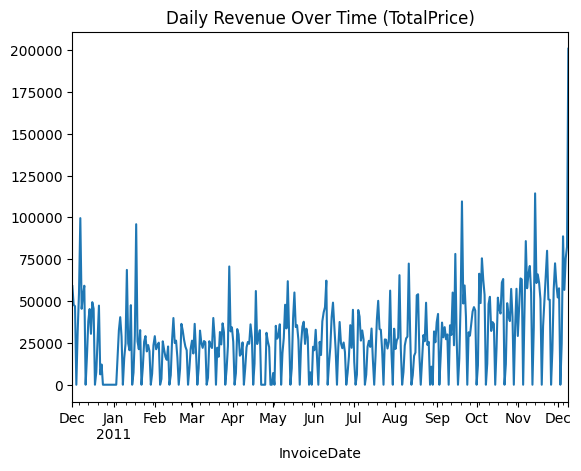

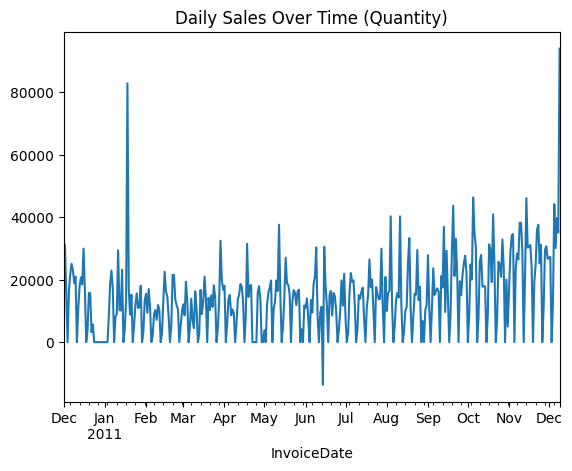

In [17]:
valid_tansactions.set_index('InvoiceDate')['TotalPrice'].resample('D').sum().plot()
plt.title('Daily Revenue Over Time (TotalPrice)')
plt.show()

valid_tansactions.set_index('InvoiceDate')['Quantity'].resample('D').sum().plot()
plt.title('Daily Sales Over Time (Quantity)')
plt.show()

#### Descriptive Statistics for Categorical Features:


Unique Values in Categorical Features:
Country: 38 unique values
StockCode: 4059 unique values
CustomerID: 4340 unique values
Cancellations: 0


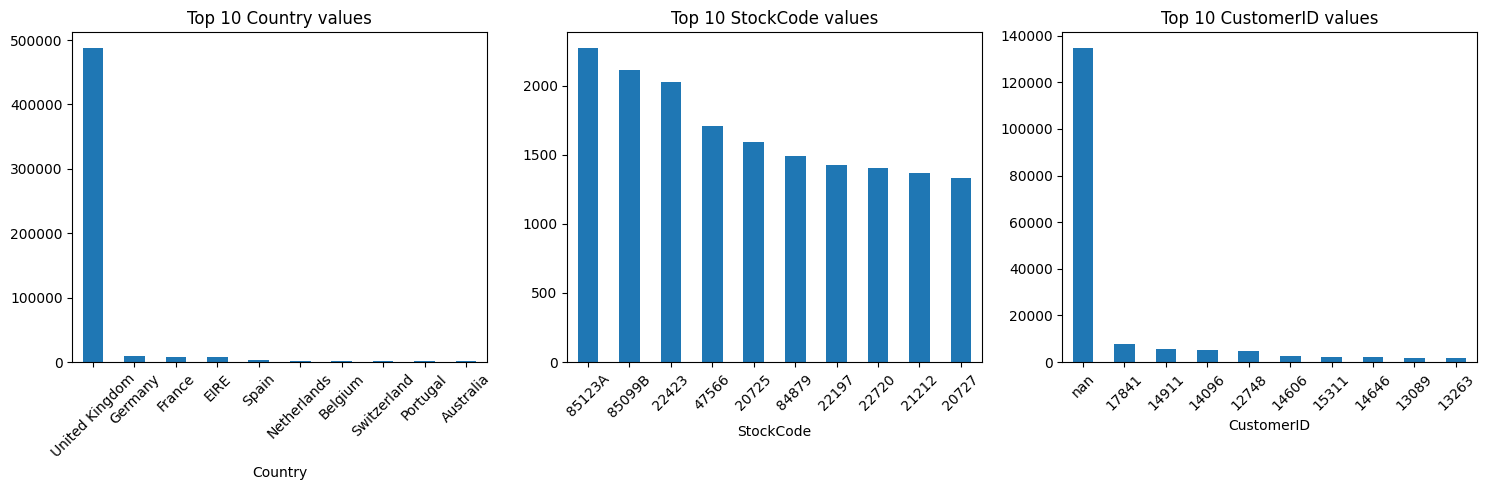

In [18]:
catergorical_cols = ['Country', 'StockCode', 'CustomerID']  # CustomerID might have too many unique values

# Categorical features summary
print("\nUnique Values in Categorical Features:")
for col in catergorical_cols:
    print(f"{col}: {valid_tansactions[col].nunique()} unique values")
print(f"Cancellations: {valid_tansactions['IsCancelled'].sum()}")

plt.figure(figsize=(15, 5))
for i, col in enumerate(catergorical_cols, 1):
    plt.subplot(1, len(catergorical_cols), i)
    valid_tansactions[col].value_counts().head(10).plot.bar()  # Top 10 only
    plt.title(f'Top 10 {col} values')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### RFM Analysis (Recency, Frequency and Monetary)

An RFM analysis can be conducted to segment customers based on their purchasing behavior using the online retail dataset. This approach helps identify high-value customers and inform targeted marketing strategies. RFM analysis was chosen as a clustering approach to segment customers without requiring predictive modeling.

To perform an RFM (Recency, Frequency, Monetary) analysis on the provided online retail dataset, we'll analyze customer purchasing behavior based on three metrics:
- Recency: how recently a customer made a purchase,
- Frequency: how often they purchase, and
- Monetary: how much they spend

CustomerID is critical for RFM analysis and cannot be imputed, we'll focus on records with non-null CustomerID values. We will also perform some additional cleanup of the data, including:
- Filter out cancellations (InvoiceNo starting with 'C').
- Remove rows with null CustomerID.
- Remove invalid records (e.g. negative quantities or prices, except for discounts).
- Calculate total transaction value (Quantity * UnitPrice).

Once the dataset is clean, we can calculate the FRM score. Quartile-based scoring (1 - 4) will be used for simplicity and interpretability.


In [19]:
# Setting up the environment
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Cleaning the dataset
def clean_data(df):
    """Clean the dataset by removing cancellations, nulls, and invalid records."""
    # Remove cancellations
    df_clean = df[~df['IsCancelled']]

    # Remove rows with null CustomerID or where CustomerID = 'nan'
    df_clean = df_clean[df_clean['CustomerID'].notnull() & ~df_clean['CustomerID'].isin(['nan'])]

    # Remove non-product entries (e.g., 'POSTAGE', 'Discount')
    df_clean = df_clean[~df_clean['StockCode'].isin(['POST', 'D'])]

    # Remove invalid quantities and prices
    df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

    # Verify no NaN CustomerIDs remain
    if df['CustomerID'].isna().sum() > 0:
        print(f"Warning: {df['CustomerID'].isna().sum()} NaN CustomerIDs remain after filtering.")

    return df_clean

# Calculating RFM metrics
def calculate_rfm(df):
    """Calculate Recency, Frequency, and Monetary metrics for each customer."""

    # Set reference date as one day after the last transaction
    reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

    # Group by CustomerID to determine RFM metrics
    rfm = df.groupby('CustomerID').agg({
        # Days since the customer’s last purchase, relative to the latest date in the dataset
        'InvoiceDate': lambda x: (reference_date - x.max()).days,
        # Number of transactions per customer
        'InvoiceNo': 'nunique',
        # Total spend per customer
        'TotalPrice': 'sum'  # Monetary
    }).reset_index()

    rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

    return rfm

# Assigning RFM scores
def assign_rfm_scores(rfm):
    """Assign quartile-based scores (1-4) for Recency, Frequency, and Monetary."""
    # Recency: Lower is better (more recent)
    rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1], duplicates='drop')

    # Frequency: Higher is better
    rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])

    # Monetary: Higher is better
    rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 4, labels=[1, 2, 3, 4])

    # Combine RFM scores
    rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
    rfm['RFM_Score'] = rfm['R_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['M_Score'].astype(int)

    return rfm

# Clean data
df_clean = clean_data(valid_tansactions)
print(f"Cleaned dataset shape: {df_clean.shape}")

# Calculate RFM
rfm = calculate_rfm(df_clean)
print(f"RFM dataset shape: {rfm.shape}")

# Assign RFM scores
rfm = assign_rfm_scores(rfm)

# Save RFM results
# rfm.to_csv('rfm_results.csv', index=False

Cleaned dataset shape: (396785, 12)
RFM dataset shape: (4338, 4)


#### Plot 1: Distribution of RFM Scores

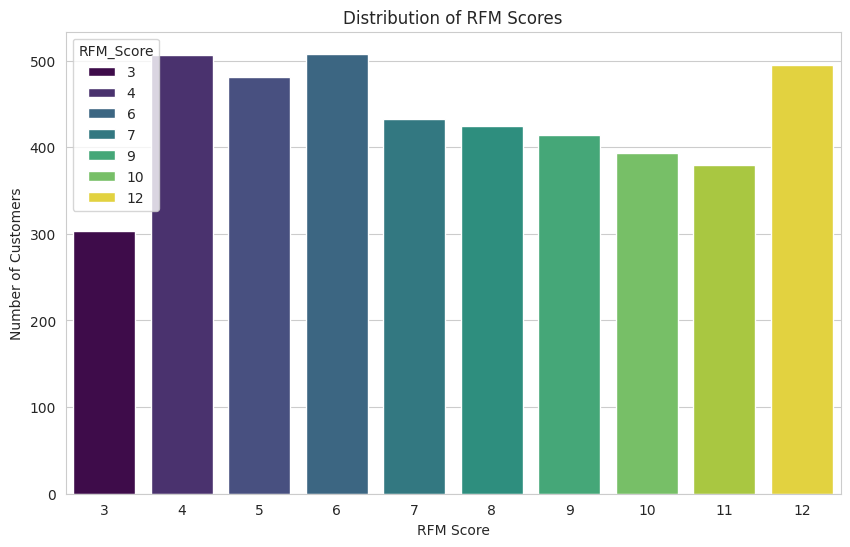

In [20]:
plt.figure()
sns.countplot(x='RFM_Score', data=rfm, palette='viridis', hue='RFM_Score')
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')
plt.show()
plt.close()

##### **Analysis**  

Overall Distribution:
- The total number of customers ranges from approximately 100 to 500, with a noticeable variation across RFM scores.
- The distribution is not uniform, with a peak around the middle scores and a decline toward the extremes.

Trends:
- The distribution shows a bimodal pattern, with peaks at RFM scores 5 and 12, suggesting two dominant customer segments: moderately engaged (score 5) and highly engaged (score 12).
- Scores 3 and 4 have fewer customers, indicating that very low engagement is less common.
- There's a general decline from score 5 to 11, with a sharp rise at 12, highlighting that the best customers (RFM 12) are a significant portion of the customer base.

##### **Insights for Business**  

- Highly Engaged Customers (RFM 12): The large number of customers with an RFM score of 12 (around 450 - 500) indicates a strong segment of recent, frequent, and high-spending customers. These are the most valuable clients and should be prioritized for retention through loyalty programs or exclusive offers.
- Moderately Engaged Customers (RFM 5): The peak at score 5 (450 - 500 customers) suggests a large middle ground of customers with moderate recency, frequency, or monetary value. Upselling or increasing purchase frequency could move them toward higher scores.
- Low Engagement (RFM 3 - 4): The smaller counts at scores 3 and 4 (100 - 450 customers) indicate a minority of less engaged customers. Re-engagement campaigns targeting these customers could prevent churn.
- Declining Middle Segment (RFM 6 - 11): The gradual decrease from 6 to 11 suggests a natural tapering of engagement levels, with fewer customers achieving higher combined scores until the spike at 12.

#### Plot 2: Recency vs. Monetary Scatter

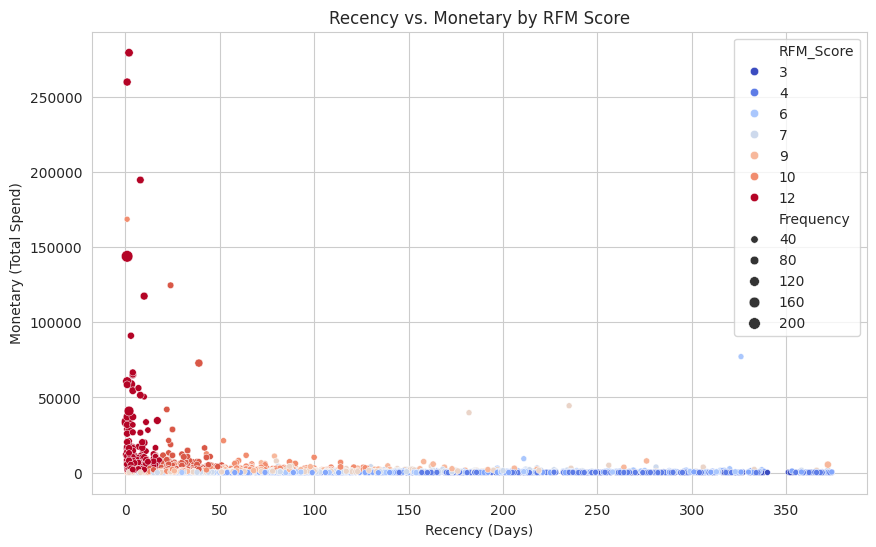

In [21]:
plt.figure()
sns.scatterplot(x='Recency', y='Monetary', hue='RFM_Score', size='Frequency', data=rfm, palette='coolwarm')
plt.title('Recency vs. Monetary by RFM Score')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary (Total Spend)')
plt.show()
plt.close()

The "Recency vs. Monetary by RFM Score" scatter plot provides insights into customer behavior based on two key RFM (Recency, Frequency, Monetary) metrics: Recency (days since the last purchase) on the x-axis and Monetary (total spend in pounds) on the y-axis. The plot uses color and size to represent RFM scores and frequency, respectively.



##### **Analysis**  

Recency Distribution:  
- Most customers are clustered between 0 and 100 days, suggesting a significant portion made purchases relatively recently.
- A smaller number of customers extend toward 300–350 days, indicating some have not purchased in nearly a year and may be at risk of churn.


Monetary Distribution:  
- The y-axis ranges from 0 to 250,000 pounds, showing a wide range of total spending. There are a few outliers that have spend exceeding 150,000 pounds.
- The majority of customers have monetary values below 50,000 pounds, with a dense cluster near the lower end.

RFM Score Distirbution:
- Low RFM Scores (3 - 7, blue to light blue): These customers, with lower combined RFM scores, are concentrated at lower monetary values (below 50,000 pounds) and higher recency values (100 - 350 days). This suggests they are less recent, less frequent, or lower spenders, potentially indicating disengagement.
- Moderate RFM Scores (9 - 10, orange): These customers appear in the middle range, with monetary values between 10,000 and 100,000 pounds and recency mostly below 150 days. They represent a moderately active segment.
- High RFM Scores (12, red): Customers with an RFM score of 12 (the highest) are sparse but notable, with monetary values ranging from 50,000 to over 200,000 pounds and recency typically below 100 days. These are the most valuable customers—recent, frequent, and high-spending.

Frequency Influence:  
- The size of the points represents frequency (number of transactions), with larger points indicating higher frequency.
- Larger points (e.g., 40 - 200 transactions) are more prominent among high RFM scores (red and orange), especially at higher monetary values, confirming that frequent purchases correlate with higher spending.
- Smaller points (lower frequency) dominate the lower RFM scores (blue), particularly at higher recency values.



##### **Insights for Business**    

- High-Value Customers: The red points (RFM score 12) indicate a small but critical segment of recent, frequent, and high-spending customers. Targeted loyalty programs or personalized offers could retain these valuable clients.
- At-Risk Customers: Blue points (RFM scores 3-7) at high recency values suggest customers who haven't purchased in months. Marketing campaigns to re-engage them could prevent churn.
- Growth Opportunities: Orange points (RFM scores 9-10) represent a middle tier with potential. Encouraging more frequent purchases or upselling could elevate them to the high-value segment.
- Frequency Correlation: The larger points among high monetary values highlight that frequency drives spending. Incentives for repeat purchases could boost overall revenue.

#### Plot 3: Top 10 Customers by Monetary Value

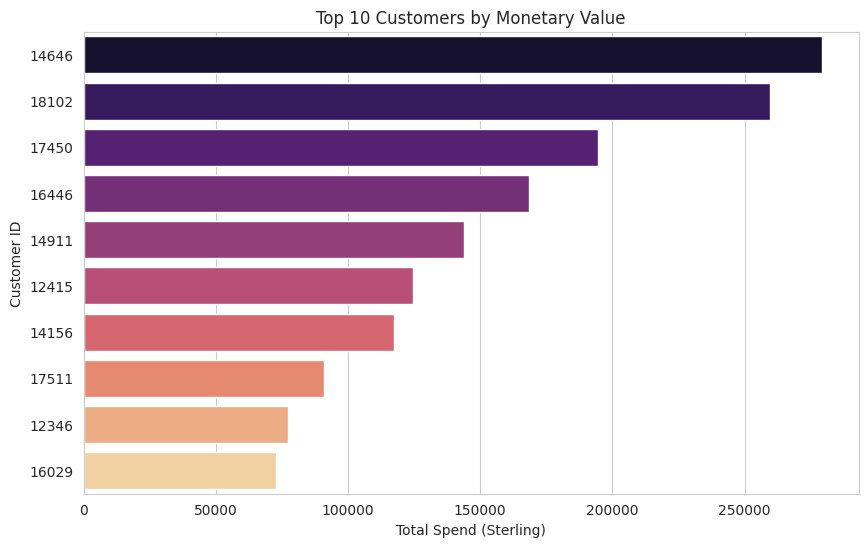

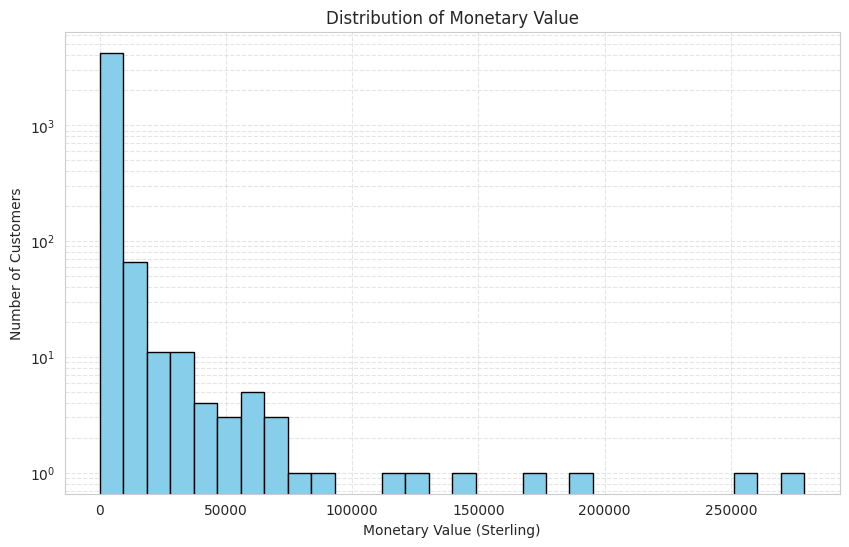

In [22]:
top_customers = rfm.nlargest(10, 'Monetary')
plt.figure()
sns.barplot(x='Monetary', y='CustomerID', hue='CustomerID', data=top_customers, palette='magma')
plt.title('Top 10 Customers by Monetary Value')
plt.xlabel('Total Spend (Sterling)')
plt.ylabel('Customer ID')
plt.show()
plt.close()

# Plot histogram of Monetary value
plt.hist(rfm['Monetary'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Monetary Value')
plt.xlabel('Monetary Value (Sterling)')
plt.ylabel('Number of Customers')
plt.yscale('log')  # Using log scale for better visibility of distribution
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()
plt.close()

##### **Analysis**:  

The histogram of monetary value shows a strogly right-skewed distribution, with most customers spending less than 50,000 Sterling, a long tail extending to 250,000 Sterling, and a few peaks corresponding to high-value customers.

The log scale helps to reveal the density of low-to-moderate spenders while still showing the rare high spenders.

##### **Insights for Business:**  

- High-Value Concentration: Customers 14646 and 18102 account for the bulk of the top spending (over 200,000 and nearly 200,000 Sterling, respectively), representing a critical segment for retention (and profitability). Personalized loyalty programs or exclusive offers could maintain their engagement.
- Mid-Tier Value: Customers like 17450, 16446, and 14911 (100,000 - 175,000 Sterling) form a second tier of valuable clients. Strategies to increase their frequency or average order value could elevate them closer to the top.
- Lower Tier in Top 10: Customers 14156, 17511, 12346, and 16029 (25,000 - 75,000 Sterling) indicate potential for growth. Upselling or cross-selling could boost their spending to match higher tiers.
- Revenue Impact: The top 10 customers collectively contribute a significant portion of revenue, with the top two alone accounting for over 400,000 Sterling. Focusing on these customers could maximize return on investment.
- Segmentation Opportunity: On the histogram, the drop-off after 50,000 Sterling suggests potential to target mid-range spenders (50,000 - 100,000 Sterling) for upselling or loyalty programs to move them toward higher spending tiers.

### Other Document Sections:

- Model Selection : Nikhil
- Model Analysis : Tamayi
- Conclusion and Recommendations: Tamayi